In [2]:
# Setup
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.models as models

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from scipy import linalg
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input


In [3]:
# Base values

n_epochs = 50
batch_size = 64
lr = 0.0002
lr_g = 0.0001
beta1 = 0.5
beta2 = 0.999
n_cpu = 8

latent_dim = 100
n_classes = 10
img_size = 28
channels = 1
sample_interval = 200

C = channels
H, W = img_size, img_size

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [4]:
# Helper functions

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight, 1.0, 0.02)
        torch.nn.init.constant(m.bias, 0.0)

In [5]:
# Generator
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1_1 = nn.Linear(100, 256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, H*W)


    # forward method
    def forward(self, input, label):
        x = F.relu(self.fc1_1_bn(self.fc1_1(input)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.tanh(self.fc4(x))
        return x
        

In [6]:
# Discriminator

class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1_1 = nn.Linear(H*W, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.fc1_1(input.view(input.size(0),-1)), 0.2)
        y = F.leaky_relu(self.fc1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)), 0.2)
        x = F.sigmoid(self.fc4(x))
        return x

In [7]:
# Training setup + Dataloader

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize Generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
train_dataset = datasets.MNIST('data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5))
                                ]))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
print('data is ok')

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25659935.21it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19741480.59it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



data is ok


In [8]:
# InceptionV3 Model for FID Score

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

  
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 118MB/s] 


In [9]:
# FID Calculation

def calculate_activation_statistics(images, model, batch_size=batch_size, dims=2048):
    model.eval()
    act=np.empty((len(images), dims))
    
    batch = images.to(device)
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


def calc_fid(real, fake, model):
    fake = torch.reshape(fake, (64, 1, 28, 28))
    fake = fake.repeat(1, 3, 1, 1)
    real = real.repeat(1, 3, 1, 1)

    mu_1, std_1 = calculate_activation_statistics(real, model)
    mu_2, std_2 = calculate_activation_statistics(fake, model)
  
    fid_val = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_val

In [11]:
# Training

g_losses = []
d_losses = []

batches_done=0
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        Batch_Size = batch_size
        N_Class = n_classes
        # Adversarial ground truths
        valid = Variable(torch.ones(Batch_Size).to(device), requires_grad=False)
        fake = Variable(torch.zeros(Batch_Size).to(device), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.FloatTensor).to(device))
        real_y = torch.zeros(Batch_Size, N_Class)
        real_y = Variable(real_y.scatter_(1, labels.view(Batch_Size, 1), 1).to(device))

        # Sample noise and labels as generator input
        noise = Variable(torch.randn((Batch_Size, latent_dim)).to(device))
        gen_labels = (torch.rand(Batch_Size, 1) * N_Class).type(torch.LongTensor)
        gen_y = torch.zeros(Batch_Size, N_Class)
        gen_y = Variable(gen_y.scatter_(1, gen_labels.view(Batch_Size, 1), 1).to(device))

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Loss for real images
        out_real = discriminator(real_imgs, real_y)
        d_real_loss = adversarial_loss(out_real.squeeze(), valid)

        # Loss for fake images
        gen_imgs = generator(noise, gen_y)
        out_fake = discriminator(gen_imgs.detach(), gen_y)
        d_fake_loss = adversarial_loss(out_fake.squeeze(), fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)
        d_loss.backward()
        optimizer_D.step()


        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        out_fake = discriminator(gen_imgs,gen_y)
        g_loss = adversarial_loss(out_fake.squeeze(), valid)
        g_loss.backward()
        optimizer_G.step()


        if i % 200 == 0:
          print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(train_loader),
                                                            d_loss.data.cpu(), g_loss.data.cpu()))
          

        batches_done = epoch * len(train_loader) + i
        
       
      
    # Each Epoch
    g_losses.append(g_loss.data.cpu())
    d_losses.append(d_loss.data.cpu())
    fid = calc_fid(real_imgs, gen_imgs, model) 

    print('Epoch %d/%d\tAvg D loss: %.4f\tAvg G loss: %.4f\tFID: %.4f\n' % (epoch, n_epochs, sum(d_losses)/(epoch+1), sum(g_losses)/(epoch+1), fid))

[Epoch 0/50] [Batch 0/937] [D loss: 0.780849] [G loss: 1.705261]
[Epoch 0/50] [Batch 200/937] [D loss: 0.527206] [G loss: 1.928178]
[Epoch 0/50] [Batch 400/937] [D loss: 0.582584] [G loss: 1.854651]
[Epoch 0/50] [Batch 600/937] [D loss: 0.579190] [G loss: 2.064527]
[Epoch 0/50] [Batch 800/937] [D loss: 0.427630] [G loss: 2.289614]
Image Saved
Epoch 0/50	Avg D loss: 0.5740	Avg G loss: 2.1328	FID: 111.7234

[Epoch 1/50] [Batch 0/937] [D loss: 0.536896] [G loss: 1.899294]
[Epoch 1/50] [Batch 200/937] [D loss: 0.578977] [G loss: 1.780946]
[Epoch 1/50] [Batch 400/937] [D loss: 0.690457] [G loss: 1.610303]
[Epoch 1/50] [Batch 600/937] [D loss: 0.491821] [G loss: 2.269290]
[Epoch 1/50] [Batch 800/937] [D loss: 0.554948] [G loss: 2.397019]
Image Saved
Epoch 1/50	Avg D loss: 0.6302	Avg G loss: 2.3950	FID: 119.4722

[Epoch 2/50] [Batch 0/937] [D loss: 0.550408] [G loss: 2.460646]
[Epoch 2/50] [Batch 200/937] [D loss: 0.607274] [G loss: 1.766852]
[Epoch 2/50] [Batch 400/937] [D loss: 0.436663] [G

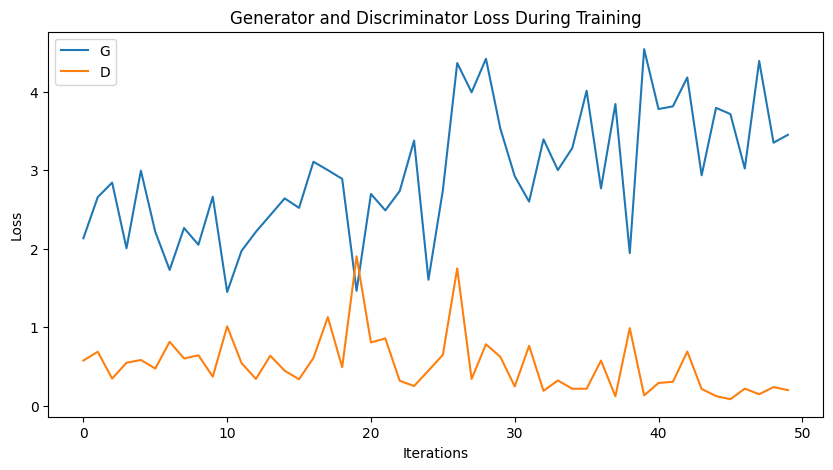

In [13]:
# Plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()